# **Skenario 7 - CNN MobileNetV2 - SVM**

Skenario 7 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur MobileNetV2 sebagai ekstraksi fitur dan SVM sebagai algoritma untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Impor semua pustaka dan modul yang dibutuhkan untuk pemrosesan data, visualisasi, pembuatan model, dan pelatihan model

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pickle

# Scikit-learn imports
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.multiclass import OneVsRestClassifier


# TensorFlow and Keras imports
import tensorflow as tf
from keras import layers, models, optimizers
from keras.utils import to_categorical
from keras.applications import MobileNetV2
from keras.layers import Input, Dense,GlobalAveragePooling2D,Flatten,MaxPool2D
from keras.models import Model

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data
Load dan proses data `image_selected.npz`

In [2]:
def load_and_preprocess_data(preprocess_images=True):
    base_dir = r"D:\Users\RESA\Coding\Alzheimer-Classification-with-CNN-SVM\Notebook\Preprocessing\image_selected.npz"
    
    # Load data from the NPZ file
    loaded_data = np.load(base_dir, allow_pickle=True)
    loaded_combined_slices = loaded_data[list(loaded_data.keys())[0]]

    # Prepare lists for input (X) and output (Y) data
    X = []
    Y = []

    # Create a label mapping for each class
    label_mapping = {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}

    # Iterate through the loaded data
    for label, plane_slices in loaded_combined_slices.item().items():
        for plane, slices in plane_slices.items():
            for selected_slice in slices:
                position, original_slice = selected_slice

                if preprocess_images:
                    # Expand dimensions and repeat for RGB representation
                    original_slice = np.expand_dims(original_slice, axis=-1)
                    original_slice = np.repeat(original_slice, 3, axis=-1)

                    # Min-Max Scaling to bring pixel values to the range [0, 1]
                    min_val = np.min(original_slice)
                    max_val = np.max(original_slice)
                    original_slice = (original_slice - min_val) / (max_val - min_val)

                X.append(original_slice)
                Y.append(label_mapping[label])

    # Convert lists to NumPy arrays
    X = np.array(X) 
    Y = np.array(Y)

    return X, Y

In [3]:
# Panggil fungsi dan simpan ke X, Y
X, Y = load_and_preprocess_data(preprocess_images=True)

In [4]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (7200, 224, 224, 3)
Y shape: (7200,)


In [5]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

### 2.2 Pembagian Data
Data dibagi dengan rasio 80:20 

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cek shape dan jumlah data

In [7]:
print("Dimensi X_train:", X_train.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train: (5760, 224, 224, 3)
Dimensi Y_train: (5760,)
Dimensi X_test: (1440, 224, 224, 3)
Dimensi Y_test: (1440,)


## 3. Buat dan Konfigurasi Model Ekstraksi Fitur
Arsitektur yang digunakan sebagai ekstraksi fitur adalah MobileNetV2 yang merupakan dari transfer learning yaitu arsitektur yang sudah dilatih dengan data ImageNet

In [8]:
from keras import backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

Load model yang udah dilatih sebelumnya

In [9]:
from keras.models import load_model

model_path = r"D:\Users\RESA\Coding\Model\M_MobileNetV2.h5"
loaded_model = load_model(model_path, custom_objects={'specificity': specificity, 'sensitivity': sensitivity})

In [10]:
extractCNN = Model(loaded_model.inputs, loaded_model.layers[-2].output)
feat_trainCNN = extractCNN.predict(X_train)
feat_testCNN = extractCNN.predict(X_test)
print("Shape of train features:", feat_trainCNN.shape)
print("Shape of test features:", feat_testCNN.shape)

45/45 [==============================] - 6s 137ms/step
Shape of train features: (5760, 512)
Shape of test features: (1440, 512)


In [11]:
feature = np.concatenate((feat_trainCNN, feat_testCNN), axis=0)
print("Shape of all features:", feature.shape)

Shape of all features: (7200, 512)


In [12]:
labels = np.concatenate((Y_train, Y_test), axis=0)
print("Shape of all features:", labels.shape)

Shape of all features: (7200,)


## 5. Training Model - Cross Validation
Latih model dengan data `X_train dan Y_train` dan menguji kinerja model pada data validasi `X_test dan Y_test`, setelah pelatihan nanti model akan menyimpan riwayatnya ke dalam `h_model`

### 5.1 Kernel RBF

Training

In [13]:
print("Size of feat_trainCNN:", feat_trainCNN.shape)
print("Size of Y:", Y.shape)

Size of feat_trainCNN: (5760, 512)
Size of Y: (7200,)


In [14]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics and model history for each fold
accuracy_per_fold = []
classification_report_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_score_per_fold = []

# Lists to store metrics and model history for each fold
roc_auc_per_class = {class_name: [] for class_name in class_names}

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(feature, labels)):
    print(f"\nTraining on fold {fold+1}/{stratified_kfold.n_splits}...")

    # Split the data into training and validation sets
    X_train_fold, X_test_fold = feature[train_index], feature[test_index]
    Y_train_fold, Y_test_fold = labels[train_index], labels[test_index]

    # Flatten the data to 2D for SVM
    X_train_fold_flat = X_train_fold.reshape(X_train_fold.shape[0], -1)
    X_test_fold_flat = X_test_fold.reshape(X_test_fold.shape[0], -1)

    # Initialize SVM classifier with parameters
    svm_rbf = SVC(kernel='rbf', decision_function_shape='ovr', probability=True)

    # Train the SVM classifier
    svm_rbf.fit(X_train_fold_flat, Y_train_fold)

    # Predict probabilities on the validation set
    Y_test_prob = svm_rbf.predict_proba(X_test_fold_flat)

    # Calculate accuracy for this fold
    accuracy_per_fold.append(accuracy_score(Y_test_fold, np.argmax(Y_test_prob, axis=1)))

    # Print classification report for each fold
    classification_rep = classification_report(Y_test_fold, np.argmax(Y_test_prob, axis=1))
    classification_report_per_fold.append(classification_rep)
    print(f"Classification Report for Fold {fold + 1}:\n{classification_rep}")

    # Calculate ROC AUC for each class
    for class_label, class_name in enumerate(class_names):
        roc_auc = roc_auc_score((Y_test_fold == class_label).astype(int), Y_test_prob[:, class_label])
        roc_auc_per_class[class_name].append(roc_auc)

    # Calculate precision, recall, and F1-score for this fold
    precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test_fold, np.argmax(Y_test_prob, axis=1), average='weighted')
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_score_per_fold.append(f1_score)


Training on fold 1/5...


Classification Report for Fold 1:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       360
           1       0.90      0.91      0.90       360
           2       0.92      0.91      0.92       360
           3       0.93      0.92      0.92       360

    accuracy                           0.92      1440
   macro avg       0.92      0.92      0.92      1440
weighted avg       0.92      0.92      0.92      1440


Training on fold 2/5...
Classification Report for Fold 2:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       360
           1       0.91      0.92      0.91       360
           2       0.88      0.92      0.90       360
           3       0.94      0.89      0.92       360

    accuracy                           0.92      1440
   macro avg       0.92      0.92      0.92      1440
weighted avg       0.92      0.92      0.92      1440


Training on fold 3/5...
Classificati

In [15]:
# Best fold index
best_rbf_fold_index = np.argmax(accuracy_per_fold)

# Split the data into training and test sets for the best fold
X_train_best_fold, X_test_best_fold = feature[train_index], feature[test_index]
Y_train_best_fold, Y_test_best_fold = labels[train_index], labels[test_index]

# Flatten the data to 2D for SVM
X_train_best_fold_flat = X_train_best_fold.reshape(X_train_best_fold.shape[0], -1)
X_test_best_fold_flat = X_test_best_fold.reshape(X_test_best_fold.shape[0], -1)

# Initialize SVM classifier with parameters
best_svm_rbf = SVC(kernel='rbf', probability=True, decision_function_shape='ovr')

# Train the SVM classifier on the best fold
best_svm_rbf.fit(X_train_best_fold_flat, Y_train_best_fold)

SVC(probability=True)

In [16]:
if best_svm_rbf.n_support_.any() > 0:
    print("Model telah dilatih.")
else:
    print("Model belum dilatih atau terdapat masalah saat pelatihan.")

Model telah dilatih.


Simpan model

In [17]:
model_svm_rbf = r"D:/Users/RESA/Coding/Model/mobilenetv2_svm_model_rbf.pkl"
with open(model_svm_rbf, 'wb') as model_file:
    pickle.dump(best_svm_rbf, model_file)

Testing

In [18]:
print("\nTesting on the unseen data...")
feat_testCNN_flat = feat_testCNN.reshape(feat_testCNN.shape[0], -1)
predictions_test = svm_rbf.predict(feat_testCNN_flat)
accuracy_test = accuracy_score(Y_test, predictions_test)

print("Label Sebenarnya:")
print(Y_test)
print("\nLabel Prediksi:")
print(predictions_test)
print("\nAkurasi pada Data Uji:", accuracy_test)


Testing on the unseen data...
Label Sebenarnya:
[1 1 2 ... 3 1 1]

Label Prediksi:
[0 1 2 ... 3 1 1]

Akurasi pada Data Uji: 0.9256944444444445


Evaluasi

In [19]:
# Predict on the validation set of the best fold
Y_test_best_pred = best_svm_rbf.predict(X_test_best_fold_flat)

# Classification report for the best fold
classification_report_best_fold = classification_report(Y_test_best_fold, Y_test_best_pred)
print("\nClassification Report for the Best Fold:\n", classification_report_best_fold)


Classification Report for the Best Fold:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94       360
           1       0.92      0.89      0.90       360
           2       0.87      0.91      0.89       360
           3       0.90      0.91      0.90       360

    accuracy                           0.91      1440
   macro avg       0.91      0.91      0.91      1440
weighted avg       0.91      0.91      0.91      1440



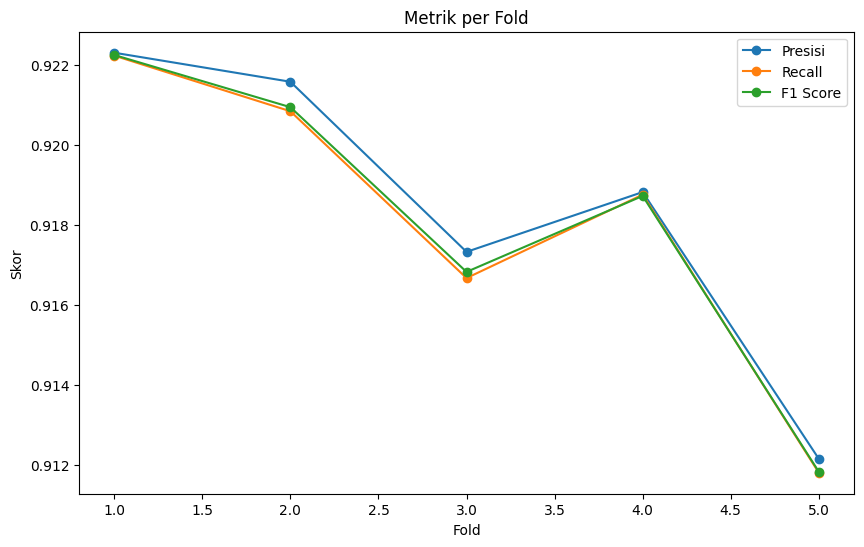

In [20]:
# Jumlah lipatan yang digunakan
n_folds = len(accuracy_per_fold)

# Plot semua metrik dlm satu grafik
plt.figure(figsize=(10, 6))

# Plot presisi
plt.plot(range(1, n_folds + 1), precision_per_fold, marker='o', label='Presisi')

# Plot recall
plt.plot(range(1, n_folds + 1), recall_per_fold, marker='o', label='Recall')

# Plot F1 score
plt.plot(range(1, n_folds + 1), f1_score_per_fold, marker='o', label='F1 Score')

plt.title('Metrik per Fold')
plt.xlabel('Fold')
plt.ylabel('Skor')
plt.legend()
plt.show()

In [21]:
# Confusion matrix for the best fold
conf_matrix_best = confusion_matrix(Y_test_best_fold, Y_test_best_pred)
print("\nConfusion Matrix for the Best Fold:\n", conf_matrix_best)


Confusion Matrix for the Best Fold:
 [[335   5  11   9]
 [  8 319  22  11]
 [  4  12 327  17]
 [  8  10  16 326]]


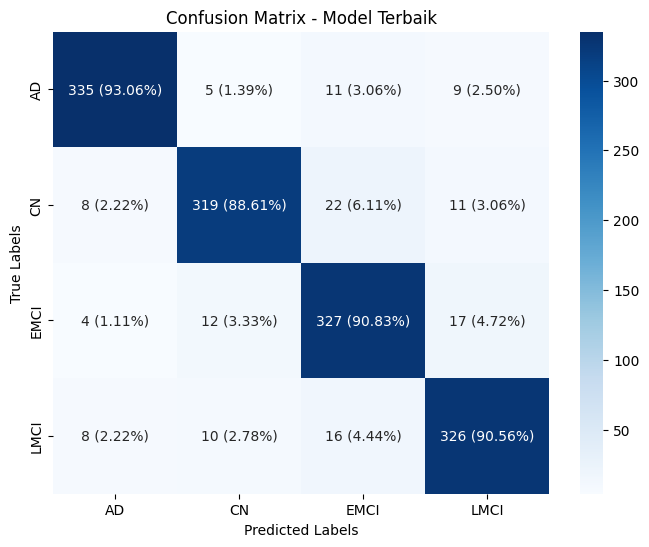

In [22]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

# Normalisasi confusion matrux untuk mendapatkan persentase
conf_matrix_percentage = conf_matrix_best.astype('float') / conf_matrix_best.sum(axis=1)[:, np.newaxis]

# Buat anotasi kustom
annotations = [['{} ({:.2%})'.format(value, percentage) for value, percentage in zip(row, row_percentage)]
               for row, row_percentage in zip(conf_matrix_best, conf_matrix_percentage)]

# Plot conf matrix dgn anotasi kustom
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=annotations, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Model Terbaik')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [23]:
# Jmlh kelas dalam data test
num_classes = len(set(Y_test))

# List untuk nyimpen sensitivitas dan spesifisitas /kelas
sensitivity = []
specificity = []

# Iterasi untuk tiap kelas
for i in range(num_classes):
    # True Positive (tp), False Negative (fn), False Positive (fp), True Negative (tn)
    tp = conf_matrix_best[i, i]
    fn = np.sum(conf_matrix_best[i, :]) - tp
    fp = np.sum(conf_matrix_best[:, i]) - tp
    tn = np.sum(conf_matrix_best) - tp - fn - fp

    # Hitung sensitivitas & spesifisitas
    sensitivity.append(tp / (tp + fn))
    specificity.append(tn / (tn + fp))

print("Sensitivitas per kelas:", sensitivity)
print("Spesifisitas per kelas:", specificity)

Sensitivitas per kelas: [0.9305555555555556, 0.8861111111111111, 0.9083333333333333, 0.9055555555555556]
Spesifisitas per kelas: [0.9814814814814815, 0.975, 0.9546296296296296, 0.9657407407407408]


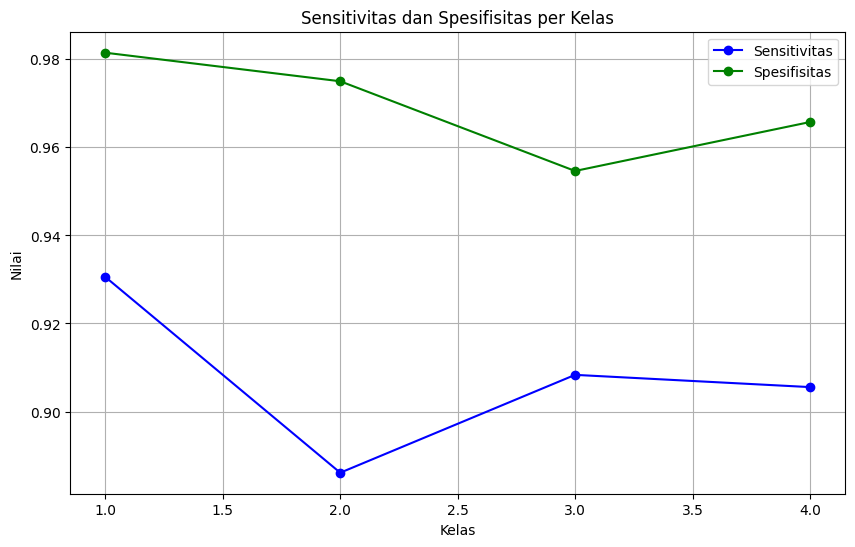

In [24]:
# Plot Sensitivitas dan Spesifisitas per kelas
class_labels = range(1, num_classes + 1)  # Label kelas dimulai dari 1, sesuaikan jika dimulai dari 0

plt.figure(figsize=(10, 6))
plt.plot(class_labels, sensitivity, marker='o', label='Sensitivitas', linestyle='-', color='blue')
plt.plot(class_labels, specificity, marker='o', label='Spesifisitas', linestyle='-', color='green')

plt.xlabel('Kelas')
plt.ylabel('Nilai')
plt.title('Sensitivitas dan Spesifisitas per Kelas')
plt.legend()
plt.grid(True)
plt.show()

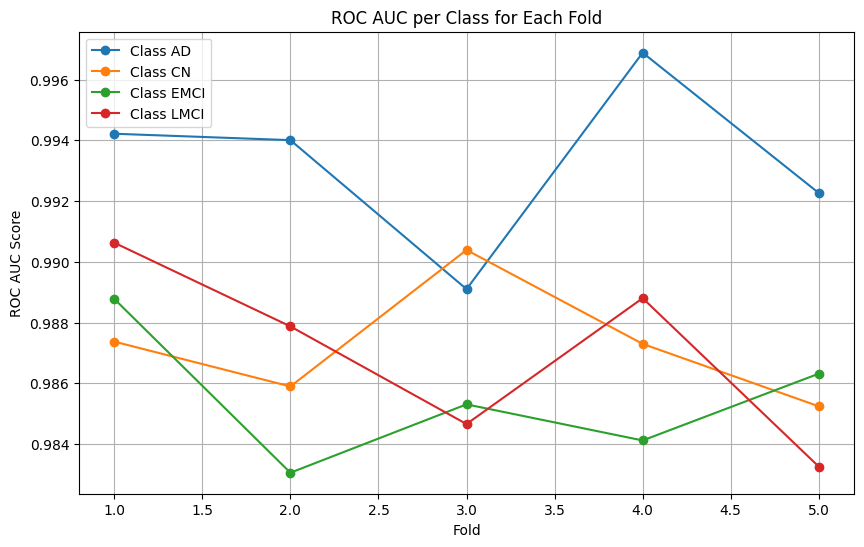

In [25]:
# Plot ROC AUC per class
plt.figure(figsize=(10, 6))

for class_names, roc_auc_values in roc_auc_per_class.items():
    plt.plot(range(1, stratified_kfold.n_splits + 1), roc_auc_values, marker='o', label=f'Class {class_names}')

plt.title('ROC AUC per Class for Each Fold')
plt.xlabel('Fold')
plt.ylabel('ROC AUC Score')
plt.legend()
plt.grid(True)
plt.show()